In [21]:
import json
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu

# from dredFISH.Design.model_v2p2_gene_constraints import CellTypeNet
from dredFISH.Design import data_loader_scrna 

config = importlib.import_module("dredfish_processing_config")

importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
class InstNrm(nn.Module):
    """
    Performs normalization on projection with thresholding by value  
    
    Attributes
    ----------
        min_pos: minimum position  
        min_sgnl: minimum signal
        max_sgnl: maximum signal
        scale: scaling factors
        noise: range of noises for Poisson parameter
    """
    def __init__(self, min_pos= 1e5, min_sgnl=5e4, max_sgnl= 2.5e5, scale= 1.5e4, noise= (1e4, 1e3)):
        super().__init__()
        self.scale= torch.tensor(scale).log()
        self.noise= noise
        self.median= torch.tensor(min_pos) # median intensity -- as each cell has half +; it is the "minimum pos" as well 
        self.min_sgnl= torch.tensor(min_sgnl)
        self.max_sgnl= torch.tensor(max_sgnl)

    def forward(self, X):
        """
        Forward propagation with Poisson noise added
        
        Attributes
        ----------
        X: (projected) gene count matrix
        
        Returns
        -------
        (X1-l)/self.scale: standardized input
        lower + upper + median: quartile error 
        """
        
        # Poisson noise
        if self.noise is None:
            X1= X.log()
        else:
            X1= (X + torch.poisson(self.noise[0]*torch.ones_like(X) + self.noise[1]*torch.randn_like(X))).log()
        # each coarse level cell type will have a median expression value, which is the difference between the last low value
        # and the first high value 
        o= X1.sort(1)[0] # sort by bits (by col). [0] - val; [1] - indices
        a= o[:,:o.shape[1]//2] # smaller half
        b= o[:,o.shape[1]//2:] # bigger half
        l= (a[:,-1:] + b[:,:1])/2 # middle values for each cell
        
        # lower and upper are bounds on expression, we want counts within their threshold
        lower= ((self.min_sgnl - X).clamp(0)**2).mean() # X lower than min
        upper= ((X - self.max_sgnl).clamp(0)**2).mean() # X larger than max
        median= ((self.median - b.exp()).clamp(0)**2).mean() # larger half lower than median  
        return (X1-l)/self.scale, lower + upper + median

In [3]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [4]:
config.bitmap

[('RS0109_cy5', 'hybe2', 'FarRed'),
 ('RS0175_cy5', 'hybe3', 'FarRed'),
 ('RS0237_cy5', 'hybe4', 'FarRed'),
 ('RS0307_cy5', 'hybe5', 'FarRed'),
 ('RS0332_cy5', 'hybe6', 'FarRed'),
 ('RS0384_atto565', 'hybe10', 'FarRed'),
 ('RS0406_atto565', 'hybe11', 'FarRed'),
 ('RS0451_atto565', 'hybe12', 'FarRed'),
 ('RS0468_atto565', 'hybe13', 'FarRed'),
 ('RS0548_atto565', 'hybe14', 'FarRed'),
 ('RS64.0_atto565', 'hybe15', 'FarRed'),
 ('RS156.0_alexa488', 'hybe19', 'FarRed'),
 ('RS278.0_alexa488', 'hybe20', 'FarRed'),
 ('RS313.0_alexa488', 'hybe21', 'FarRed'),
 ('RS643.0_alexa488', 'hybe22', 'FarRed'),
 ('RS740.0_alexa488', 'hybe23', 'FarRed'),
 ('RS810.0_alexa488', 'hybe24', 'FarRed'),
 ('RSN9927.0_cy5', 'hybe7', 'FarRed'),
 ('RSN2336.0_cy5', 'hybe8', 'FarRed'),
 ('RSN1807.0_cy5', 'hybe9', 'FarRed'),
 ('RSN4287.0_atto565', 'hybe16', 'FarRed'),
 ('RSN1252.0_atto565', 'hybe17', 'FarRed'),
 ('RSN9535.0_atto565', 'hybe18', 'FarRed'),
 ('RS0095_cy5', 'hybe1', 'FarRed'),
 ('PolyT', 'hybe25', 'FarRed')]

In [5]:
pmat_cols = [bit[0].split('_')[0] for bit in config.bitmap[:24]]

In [6]:
pth = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna"
f = os.path.join(pth, "dredFISH_NN_Igor_gene.csv")
pmat = pd.read_csv(f, index_col=0)[pmat_cols]
genes_igor = pmat.index.values

prx = torch.from_numpy(pmat.values).float()
print(pmat.shape, prx.shape)
pmat.columns

(3853, 24) torch.Size([3853, 24])


Index(['RS0109', 'RS0175', 'RS0237', 'RS0307', 'RS0332', 'RS0384', 'RS0406',
       'RS0451', 'RS0468', 'RS0548', 'RS64.0', 'RS156.0', 'RS278.0', 'RS313.0',
       'RS643.0', 'RS740.0', 'RS810.0', 'RSN9927.0', 'RSN2336.0', 'RSN1807.0',
       'RSN4287.0', 'RSN1252.0', 'RSN9535.0', 'RS0095'],
      dtype='object')

In [7]:
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=500,
)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters

In [8]:
genes_data = tst_dataloader.dataset.data['genes'][:] #.Genes

# Igor's gene is a subset -- good
genes_comm = np.intersect1d(genes_igor, genes_data)
print(genes_data.shape, genes_igor.shape, genes_comm.shape)

# get idx
genes_igor_idx = basicu.get_index_from_array(genes_data, genes_igor)
genes_igor_idx.shape, genes_igor_idx

(45768,) (3853,) (3853,)


((3853,), array([45613,  7331, 44010, ..., 42094, 38854, 36972]))

In [9]:
# almost
genes_cnst = genes_data[cnstrnts_idx]
genes_withcnst = np.intersect1d(genes_igor, genes_cnst)
used = pmat.loc[genes_withcnst].sum(axis=1).values
allowed = cnstrnts[basicu.get_index_from_array(cnstrnts_idx, basicu.get_index_from_array(genes_data, genes_withcnst))].numpy()

print(genes_igor.shape, genes_withcnst.shape, used.shape, allowed.shape)

(3853,) (3850,) (3850,) (3850,)


In [10]:
nrmNN = InstNrm()

In [11]:
# validation dataset
ftrs, clsts = next(iter(tst_dataloader))
ftrs  = ftrs.float()#.numpy() # all features
clsts = clsts.long()#.numpy()
ftrs  = ftrs[:,genes_igor_idx] # input features (otherwise throw away)
print(ftrs.shape, clsts.shape)

prjx = ftrs.mm(prx)
embx, _reg = nrmNN.forward(prjx)

prjx = prjx.numpy()
embx = embx.numpy()
clsts = clsts.numpy()
prjx.shape, embx.shape, clsts.shape

torch.Size([500, 3853]) torch.Size([500])


((500, 24), (500, 24), (500,))

In [12]:
nzero_prbe_cond = pmat.sum(axis=1) > 0
pospmat = pmat[nzero_prbe_cond]
fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)

prjx_clsts, _ = basicu.group_mean(prjx, clsts)

embx_clsts, _ = basicu.group_mean(embx, clsts)
embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
embx_clsts_corr = np.corrcoef(embx_clsts_z)

# order by HC
_rows = order_by_hc(embx_clsts)
_cols = order_by_hc(embx_clsts.T)

In [13]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts)]
type_orders

array(['Astro', 'CA1-ProS', 'CT SUB', 'Car3', 'DG', 'Endo', 'L2 IT ENTl',
       'L2 IT ENTm', 'L2/3 IT CTX', 'L2/3 IT ENTl', 'L2/3 IT PPP',
       'L2/3 IT RHP', 'L3 IT ENT', 'L4 RSP-ACA', 'L4/5 IT CTX',
       'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT TPE-ENT', 'L5/6 NP CTX',
       'L6 CT CTX', 'L6 IT CTX', 'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT',
       'Lamp5', 'Meis2', 'Micro-PVM', 'NP SUB', 'Oligo', 'Pvalb', 'Sncg',
       'Sst', 'Sst Chodl', 'VLMC', 'Vip'], dtype='<U15')

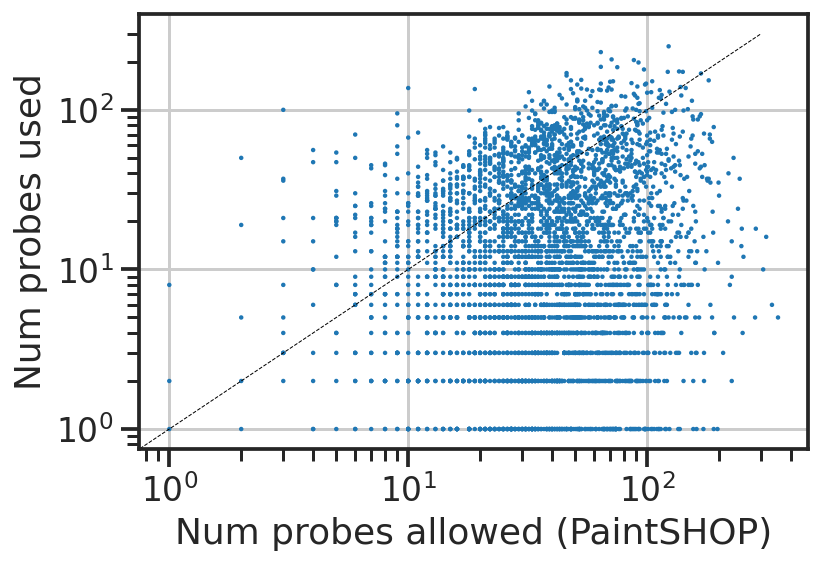

In [14]:
fig, ax = plt.subplots()
ax.scatter(allowed, used, s=5, edgecolor='none')
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlabel('Num probes allowed (PaintSHOP)')
ax.set_ylabel('Num probes used')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

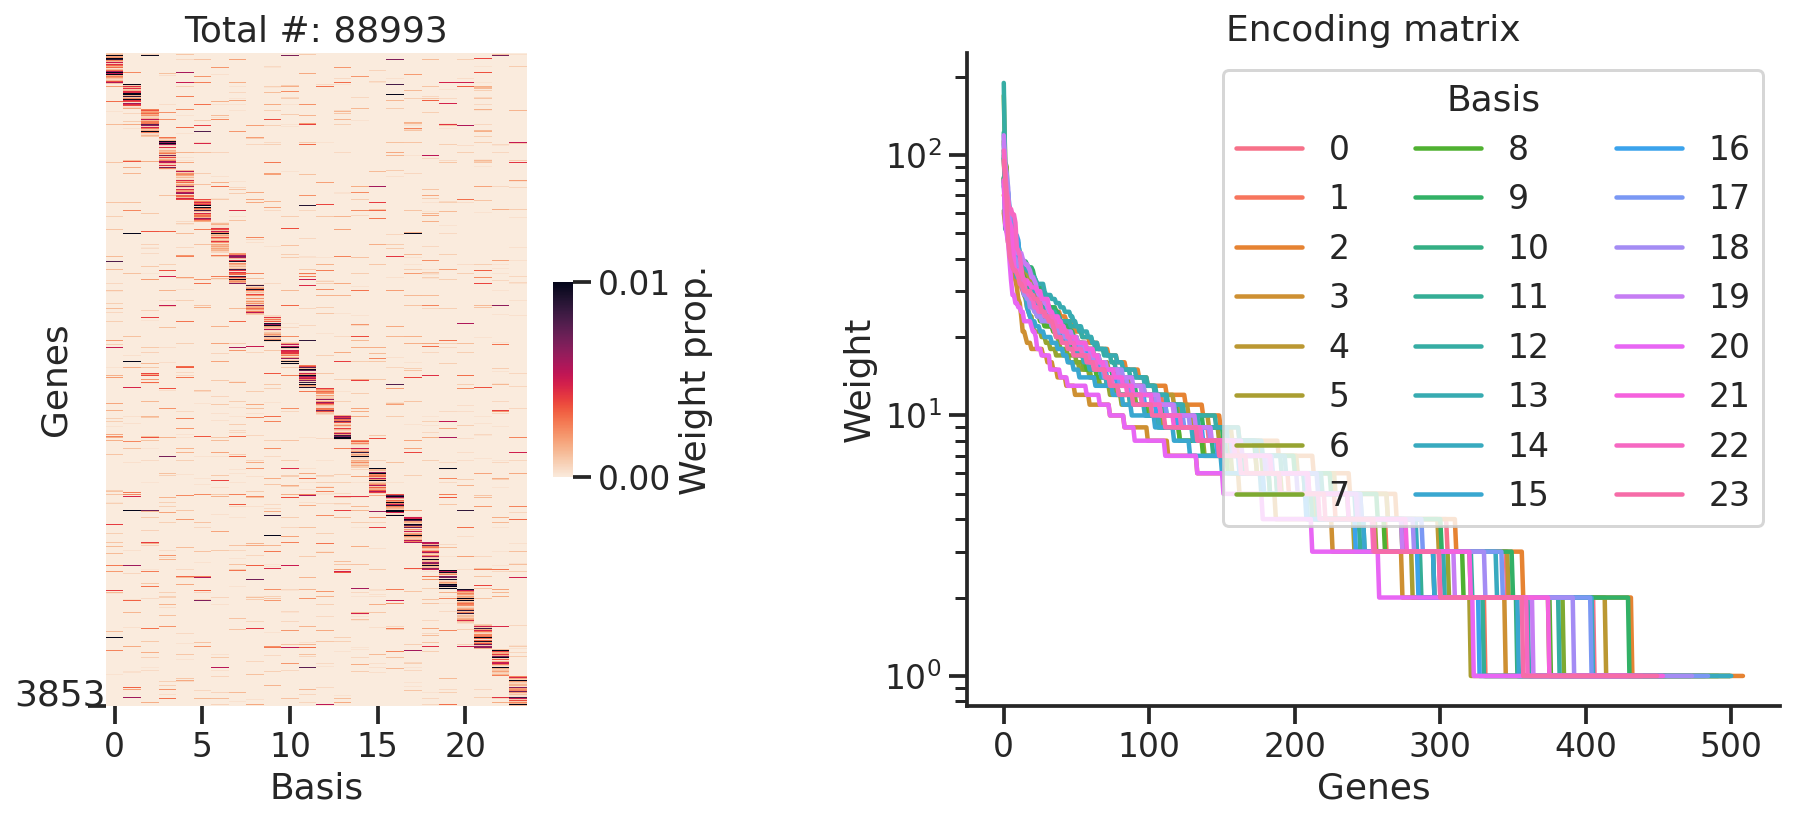

In [15]:
designu.plot_enc(pmat, fpmat)

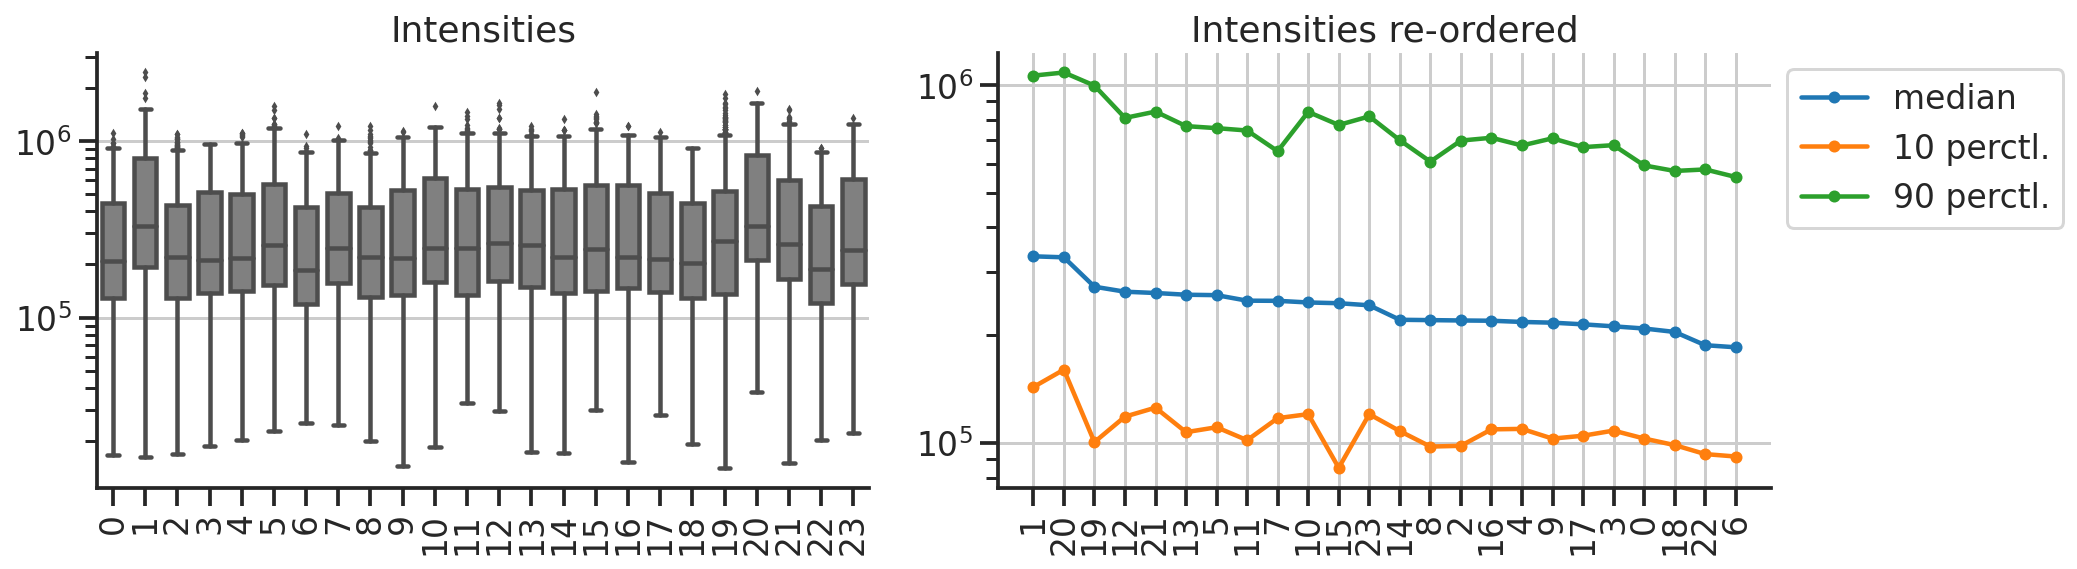

In [22]:
designu.plot_intn(prjx)

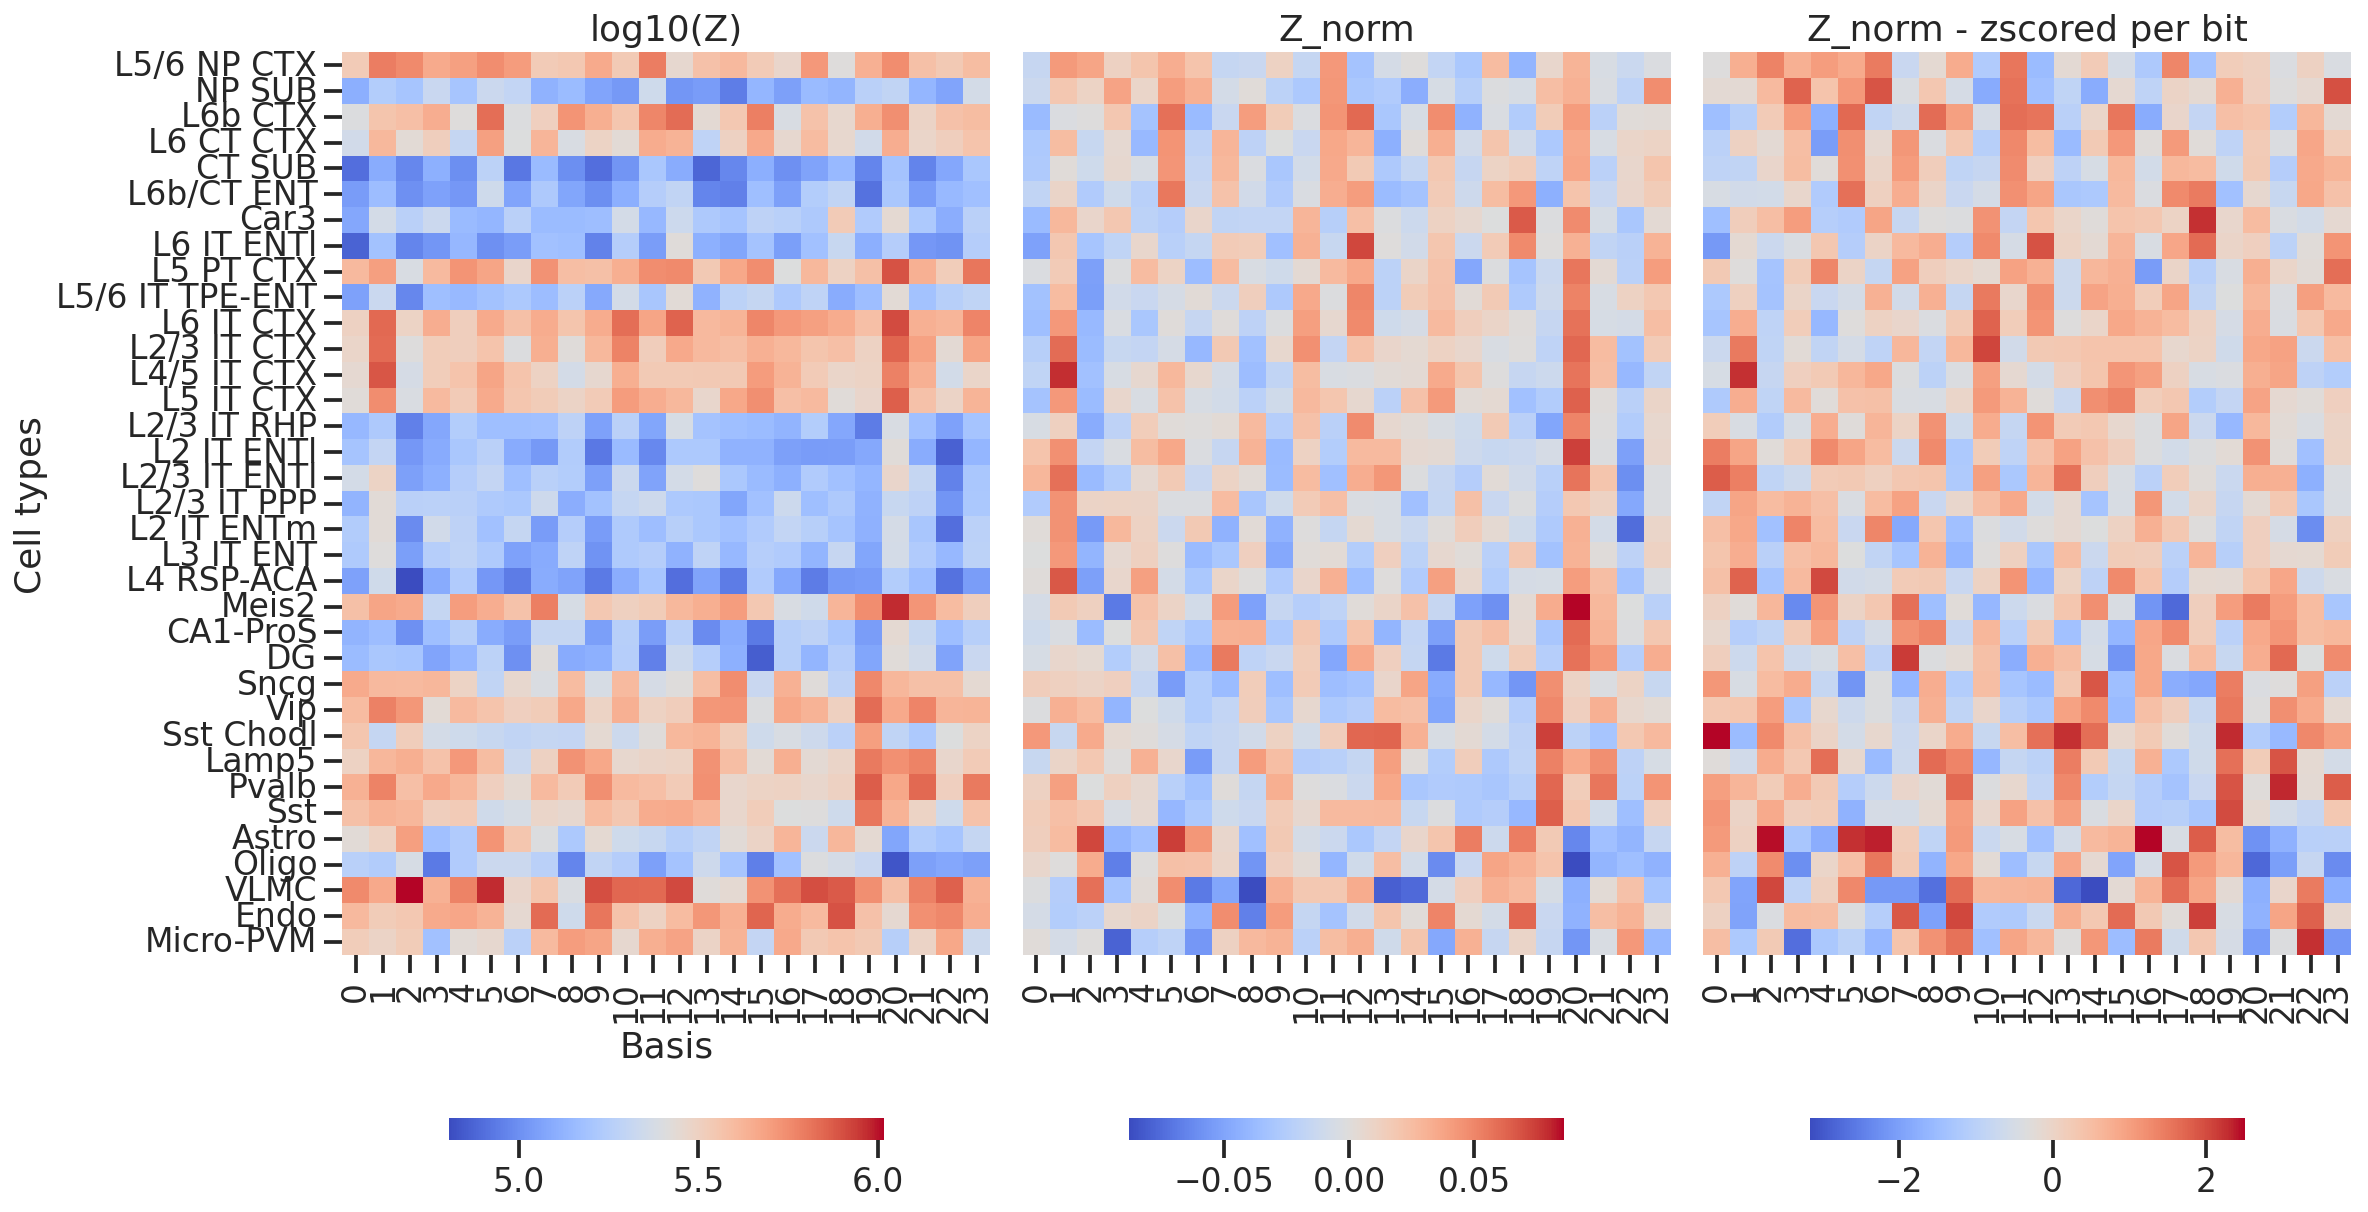

In [17]:
# rows and cols
# designu.plot_embx_clsts(prjx_clsts, embx_clsts, embx_clsts_z, 
#                         rownames=type_orders, 
#                         colnames=np.arange(24), 
#                         _rows=_rows, _cols=_cols, 
#                         figsize=(3*6, 1*10),
#                        )

# rows only
designu.plot_embx_clsts(prjx_clsts, embx_clsts, embx_clsts_z, 
                        rownames=type_orders, 
                        colnames=np.arange(24), 
                        _rows=_rows, _cols=None, 
                        figsize=(3*6, 1*10),
                       )

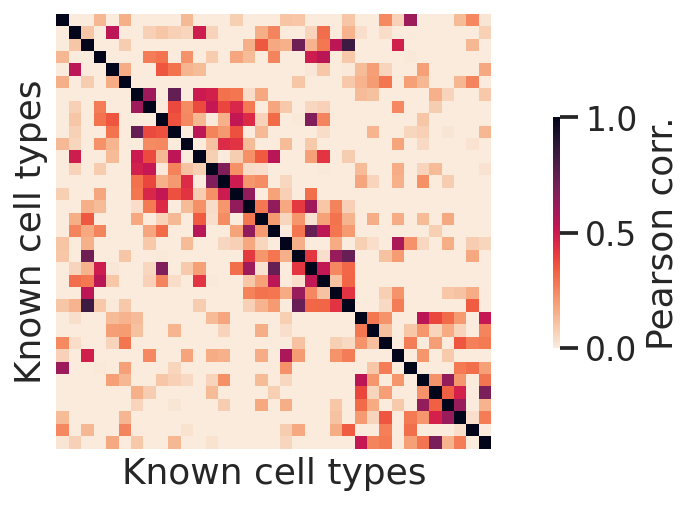

In [18]:
designu.plot_heatcorr(embx_clsts_corr, vmin=0)